In [103]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer # useful to enable the experimental IterativeImputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

sns.set_theme()

### Definition of input folder

In [104]:
folder_path = "../study"
stats_path = folder_path + "/stats"

### Concatenation of all patient's metrics

In [105]:
## Read the list of subjects and for each subject do the tractography
dest_success = folder_path + "/subjects/subj_list.json"
with open(dest_success, 'r') as file:
    patient_list = json.load(file)
del file

dfs = []
for p_code in patient_list:
    metric_folder = "%s/subjects/%s/dMRI/microstructure/%s_metrics.csv" % (folder_path, p_code, p_code)
    if not os.path.exists(metric_folder):
        print(metric_folder, "doesn't exists")
        continue
    dfs.append(pd.read_csv(metric_folder))
    del metric_folder
del p_code

df = pd.concat(dfs, ignore_index=True)
del dfs

"""
Check that there are the expected number of columns:
23 metrics, 4 measure for each metric, 5 tracts, 4 roi, 2 means right and left
For each tract we measure the number of tracts found
The ID
"""
assert df.columns.size == 23 * 4 * (5+4) * 2 + (5*2) + 1 # 1656

info_df = pd.read_csv(stats_path + "/info.csv")
non_dMRIfeatures = info_df.columns.drop(["ID"])

df = pd.merge(info_df, df, on="ID")
del info_df

if not os.path.isdir(stats_path):
    os.mkdir(stats_path)

df.to_csv("%s/dataset.csv" % stats_path, index=False)

# Exploration

# Features names:
```json
metrics = {
    "dti" : ["FA", "AD", "RD", "MD"],
    "noddi" : ["icvf", "odi", "fbundle", "fextra", "fintra", "fiso" ],
    "diamond" : ["wFA", "wMD", "wAxD", "wRD", "frac_c0", "frac_c1", "frac_csf_d"],
    "mf" : ["fvf_f0", "fvf_f1", "fvf_tot", "frac_f0", "frac_f1", "frac_csf_mf"]
}

masks_name = [
    "thalamus",
    "hippocampus",
    "amygdala",
    "accumbens",
    "putamen",
    "pallidum",

    "fornix",
    "inf-longi-fasci",
    "sup-longi-fasci",
    "thalamus-AntCingCtx",
    "thalamus-Insula",
]
```

They are composed in the following manner:

[right|left]-[mask_name]\_[metrics]\_[mean|std|skew|kurt]

In [106]:
non_dMRIfeatures = ['resp', 'respPart', 'age', 'therapy_duration', 'sex', 'AEDs', 'benzo', 'epilepsy_onset_age', 'epilepsy_type', 'epilepsy_duration']
col_nTract = df.columns.str.extractall(r'(^.*_nTracts$)')[0]
col_means = df.columns.str.extractall(r'(^.*mean$)')[0]

In [107]:
# Reading the whole dataset
df = pd.read_csv("%s/dataset.csv" % stats_path, index_col="ID")

In [108]:
df.head()

,resp,respPart,age,therapy_duration,sex,AEDs,benzo,epilepsy_onset_age,epilepsy_type,epilepsy_duration,...,right-hippocampus_frac_csf_mf_skew,right-hippocampus_frac_csf_mf_kurt,right-amygdala_frac_csf_mf_mean,right-amygdala_frac_csf_mf_std,right-amygdala_frac_csf_mf_skew,right-amygdala_frac_csf_mf_kurt,right-accumbens-area_frac_csf_mf_mean,right-accumbens-area_frac_csf_mf_std,right-accumbens-area_frac_csf_mf_skew,right-accumbens-area_frac_csf_mf_kurt
ID,,,,,,,,,,,,,,,,,,,,,
VNSLC_01,1,2,36,93,1,3,0,5,1,31,...,0.023179,0.018156,0.137069,0.138784,0.006900,0.003930,0.103991,0.118798,0.003639,0.001688
VNSLC_02,1,2,29,13,2,2,0,14,1,15,...,0.060498,0.049116,0.218807,0.295680,0.048082,0.039077,0.087669,0.115187,0.011297,0.010479
VNSLC_03,1,2,65,234,1,3,0,15,1,50,...,0.038515,0.031084,0.267605,0.248778,0.024306,0.019431,0.123216,0.046279,-0.000059,0.000025
VNSLC_04,1,2,34,11,2,2,0,8,2,26,...,0.049910,0.040012,0.137749,0.197970,0.024946,0.021099,0.076892,0.136489,0.014051,0.012932
VNSLC_06,0,0,62,136,2,2,0,36,2,26,...,0.043707,0.035947,0.155287,0.243089,0.040690,0.034923,0.049738,0.068137,0.000819,0.000304


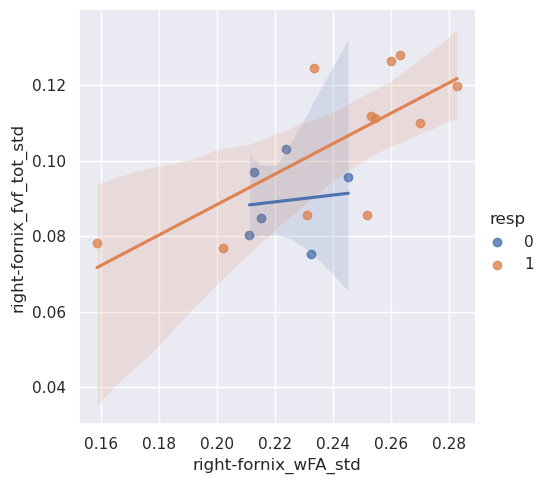

In [124]:
sns.lmplot(df, x="right-fornix_wFA_std", y="right-fornix_fvf_tot_std", hue="resp")

<Axes: xlabel='resp', ylabel='right-fornix_frac_csf_mf_kurt'>

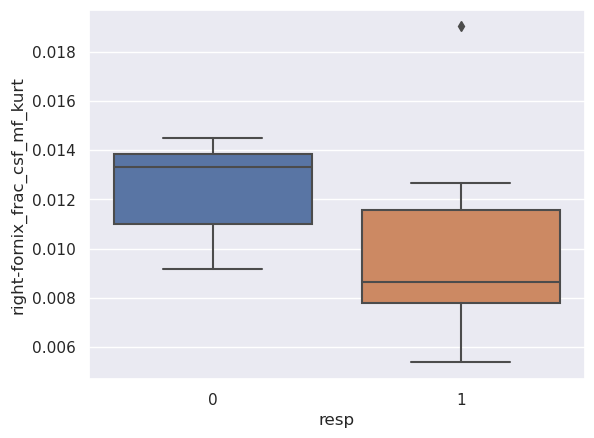

In [137]:
sns.boxplot(df, y="right-fornix_frac_csf_mf_kurt", x="resp")

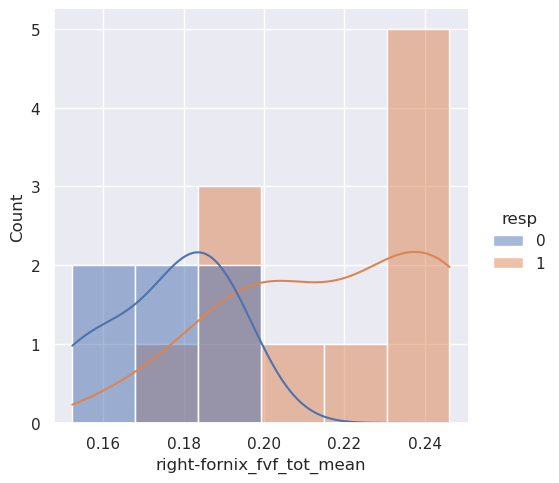

In [122]:
sns.displot(df, x="right-fornix_f_tot_mean", hue="resp", kde=True)

# Managing of NaN values

There are different method to handle the missing values:
- Deleting the rows
- Imputing the missing values with the mean/median
- Predicting the missing values (Machine Learning with sklearn) https://scikit-learn.org/stable/modules/impute.html

For the ROI taken from tracts we will use a prediction method to impute the NaN values

In [219]:
(df[col_nTract] == 0).sum(axis=1)
(df[col_nTract] == 0).sum(axis=0)
df[col_nTract].loc[(df[col_nTract] == 0).sum(axis=1) > 0, (df[col_nTract] == 0).sum(axis=0) > 0]


,left-fornix_nTracts,right-fornix_nTracts,right-thalamus-AntCingCtx_nTracts
ID,,,
VNSLC_03,0,0,253
VNSLC_17,79,0,0
VNSLC_19,1958,37,0


In [208]:
# PRINT THE NULL VALUES
(df.isnull().sum(axis=0) > 0)# only the features with NaN values
(df.isnull().sum(axis=1) > 0) # only the subjects with NaN valuse
df[col_means].loc[(df.isnull().sum(axis=1) > 0), (df.isnull().sum(axis=0) > 0)] # 276 columns because 3*4*23

,left-fornix_FA_mean,right-fornix_FA_mean,right-thalamus-AntCingCtx_FA_mean,left-fornix_AD_mean,right-fornix_AD_mean,right-thalamus-AntCingCtx_AD_mean,left-fornix_RD_mean,right-fornix_RD_mean,right-thalamus-AntCingCtx_RD_mean,left-fornix_MD_mean,...,right-thalamus-AntCingCtx_fvf_tot_mean,left-fornix_frac_f0_mean,right-fornix_frac_f0_mean,right-thalamus-AntCingCtx_frac_f0_mean,left-fornix_frac_f1_mean,right-fornix_frac_f1_mean,right-thalamus-AntCingCtx_frac_f1_mean,left-fornix_frac_csf_mf_mean,right-fornix_frac_csf_mf_mean,right-thalamus-AntCingCtx_frac_csf_mf_mean
ID,,,,,,,,,,,,,,,,,,,,,
VNSLC_03,NaN,NaN,0.494763,NaN,NaN,0.000738,NaN,NaN,0.000318,NaN,...,0.279393,NaN,NaN,0.705406,NaN,NaN,0.146495,NaN,NaN,0.148099
VNSLC_17,0.481567,NaN,NaN,0.001127,NaN,NaN,0.000488,NaN,NaN,0.000701,...,NaN,0.509189,NaN,NaN,0.055898,NaN,NaN,0.434913,NaN,NaN
VNSLC_19,0.450190,0.344493,NaN,0.000895,0.000904,NaN,0.000412,0.000533,NaN,0.000573,...,NaN,0.497861,0.375888,NaN,0.095406,0.10674,NaN,0.406733,0.517372,NaN


In [225]:
df.columns.str.extractall(r'(^.*_mean.*$)')[0]

      match
11    0                  left-inf-longi-fasci_FA_mean
16    0                           left-fornix_FA_mean
21    0                 right-inf-longi-fasci_FA_mean
26    0                  left-sup-longi-fasci_FA_mean
31    0                          right-fornix_FA_mean
                                ...                  
1656  0          left-accumbens-area_frac_csf_mf_mean
1660  0        right-thalamus-proper_frac_csf_mf_mean
1664  0            right-hippocampus_frac_csf_mf_mean
1668  0               right-amygdala_frac_csf_mf_mean
1672  0         right-accumbens-area_frac_csf_mf_mean
Name: 0, Length: 414, dtype: object

In [220]:
df_imputation = df[[ *non_dMRIfeatures, *col_nTract.to_numpy(), *df.columns[(df.isnull().sum(axis=0) > 0)].to_list()]]
#p = df[df.columns[(df.isnull().sum(axis=0) > 0)].to_list()]
df[df.columns.str.extractall(r'(^.*(fornix|AntCingCtx)_fvf_tot_mean.*$)')[0]]

,left-fornix_fvf_tot_mean,right-fornix_fvf_tot_mean,right-thalamus-AntCingCtx_fvf_tot_mean,left-thalamus-AntCingCtx_fvf_tot_mean
ID,,,,
VNSLC_01,0.189926,0.197733,0.281463,0.291882
VNSLC_02,0.267442,0.246181,0.302454,0.286721
VNSLC_03,NaN,NaN,0.279393,0.334097
VNSLC_04,0.174664,0.195073,0.236043,0.289461
VNSLC_06,0.155937,0.177949,0.275619,0.289660
VNSLC_07,0.224874,0.223416,0.304707,0.304479
VNSLC_09,0.239097,0.244596,0.300435,0.355334
VNSLC_10,0.198601,0.234348,0.278099,0.284875
VNSLC_11,0.228182,0.170478,0.242165,0.303920


#### Mean imputation

Show the means, to understand if the probabilistic imputation is better than the mean/median.

In [221]:
df[df.columns.str.extractall(r'(^.*(fornix|AntCingCtx)_fvf_tot_mean.*$)')[0]].mean()

left-fornix_fvf_tot_mean                  0.210776
right-fornix_fvf_tot_mean                 0.203125
right-thalamus-AntCingCtx_fvf_tot_mean    0.283196
left-thalamus-AntCingCtx_fvf_tot_mean     0.306878
dtype: float64

#### Probabilistic imputation

In [223]:
# imp = IterativeImputer(estimator=BayesianRidge(), max_iter=50)
imp = KNNImputer()
arr = imp.fit_transform(df_imputation)

# Transform to Dataframe
df_imputed = pd.DataFrame(arr)
df_imputed.columns = df_imputation.columns
df_imputed.index = df_imputation.index

# keep oly the dMRI features and show the difference
df_imputed = df_imputed.drop([*non_dMRIfeatures, *col_nTract.to_numpy()], axis=1)
df_imputed[df_imputed.columns.str.extractall(r'(^.*(fornix|AntCingCtx)_fvf_tot_mean.*$)')[0]]

,left-fornix_fvf_tot_mean,right-fornix_fvf_tot_mean,right-thalamus-AntCingCtx_fvf_tot_mean
ID,,,
VNSLC_01,0.189926,0.197733,0.281463
VNSLC_02,0.267442,0.246181,0.302454
VNSLC_03,0.205924,0.194896,0.279393
VNSLC_04,0.174664,0.195073,0.236043
VNSLC_06,0.155937,0.177949,0.275619
VNSLC_07,0.224874,0.223416,0.304707
VNSLC_09,0.239097,0.244596,0.300435
VNSLC_10,0.198601,0.234348,0.278099
VNSLC_11,0.228182,0.170478,0.242165


In [156]:
# put the imputed inside the original data frame
dMRI_ROIs = df.drop([*non_dMRIfeatures, *col_nTract.to_numpy()], axis=1).columns
if df.isnull().sum().sum() > 0:
    df[df.columns[(df.isnull().sum(axis=0) > 0)].to_list()] = df_imputed

df.isnull().sum().sum() # show that there are not NaN anymore :P

0

### Analysis over the number of streamline for tract

We have generated 2M of seed to generate the streamlines for each ROI tract. So, there are some patients have 4k streamlines for the fornix and some that have 0 streamlines.

This is a value that depends on the physical structure of the tract in the patient. A small value means a damaged or missing structure, because wan't found any streamline that compose the ROI.

In [172]:
missingTracts4subject = (df_nTracts == 0).sum(axis=1) # number of missing ROI tracts for subject
df_nTracts[missingTracts4subject != 0]

,left-inf-longi-fasci_nTracts,left-fornix_nTracts,right-inf-longi-fasci_nTracts,left-sup-longi-fasci_nTracts,right-fornix_nTracts,left-thalamus-Insula_nTracts,right-thalamus-AntCingCtx_nTracts,right-sup-longi-fasci_nTracts,right-thalamus-Insula_nTracts,left-thalamus-AntCingCtx_nTracts
ID,,,,,,,,,,
VNSLC_03,40162,0,65551,22072,0,33874,253,22044,13176,1
VNSLC_17,81081,79,95533,18835,0,47258,0,25588,41427,103
VNSLC_19,93490,1958,202321,21087,37,10839,0,1920,121,10


### Normalization

# Division between features and label

In this first analysis we consider a binary classification problem. Therefore, we keep the NR-RP/R labels, in which the Partial responders are considered as Responders.

*In next analysis we will consider a multiclass classification problem, trying to classify all the three different types* 

In [11]:
y = df["NR-RP/R"]
X = df.drop(["NR-RP/R", "NR-RP-R"], axis=1) 

Here the explanation of some features:

NR-RP/R:

- NR-RP/R == 0 => Non Responder
- NR-RP/R == 1 => Partial responder or Responder

NR-RP-R:

- NR-RP-R == 0 => Non Responder
- NR-RP-R == 1 => Partial Responder
- NR-RP-R == 2 => Responder

epilepsy_type:

- epilepsy_type == 1 => Generalized
- epilepsy_type == 2 => Focal

In [12]:
X.describe()

,age,therapy_duration,sex,AEDs,benzo,epilepsy_onset_age,epilepsy_type,epilepsy_duration,left-inf-longi-fasci_nTracts,left-inf-longi-fasci_FA_mean,...,right-hippocampus_frac_csf_mf_skew,right-hippocampus_frac_csf_mf_kurt,right-amygdala_frac_csf_mf_mean,right-amygdala_frac_csf_mf_std,right-amygdala_frac_csf_mf_skew,right-amygdala_frac_csf_mf_kurt,right-accumbens-area_frac_csf_mf_mean,right-accumbens-area_frac_csf_mf_std,right-accumbens-area_frac_csf_mf_skew,right-accumbens-area_frac_csf_mf_kurt
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,...,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,38.666667,90.611111,1.555556,2.833333,0.111111,12.722222,1.833333,28.055556,59257.055556,0.543739,...,0.036395,0.030623,0.206393,0.241785,0.028967,0.025422,0.113486,0.152597,0.018556,0.016452
std,12.078177,74.548160,0.511310,0.785905,0.323381,9.086548,0.383482,12.065860,23980.872553,0.039047,...,0.014571,0.011314,0.114068,0.078855,0.016642,0.013184,0.062781,0.087362,0.018028,0.016063
min,21.000000,6.000000,1.000000,2.000000,0.000000,0.000000,1.000000,9.000000,25198.000000,0.424548,...,0.002495,0.001317,0.114145,0.083668,-0.000202,0.000411,0.039018,0.046279,-0.000059,0.000025
25%,30.250000,13.500000,1.000000,2.000000,0.000000,6.000000,2.000000,18.750000,43664.250000,0.533987,...,0.027815,0.023190,0.146565,0.208731,0.022672,0.019668,0.078893,0.096344,0.003654,0.002096
50%,35.000000,91.500000,2.000000,3.000000,0.000000,12.000000,2.000000,26.000000,53947.500000,0.545210,...,0.040102,0.032842,0.163038,0.236106,0.029069,0.025069,0.101168,0.145072,0.014379,0.013142
75%,46.000000,133.500000,2.000000,3.000000,0.000000,18.000000,2.000000,36.000000,71056.750000,0.563859,...,0.044145,0.039250,0.213759,0.275783,0.042991,0.035843,0.132212,0.189972,0.027846,0.024605
max,65.000000,234.000000,2.000000,4.000000,1.000000,36.000000,2.000000,50.000000,119642.000000,0.591488,...,0.060498,0.049116,0.575384,0.404089,0.054867,0.045849,0.326714,0.423940,0.068698,0.060285


In [12]:
print(df["NR-RP/R"].value_counts())
print(df["NR-RP-R"].value_counts())

NR-RP/R
1    12
0     6
Name: count, dtype: int64
NR-RP-R
2    8
0    6
1    4
Name: count, dtype: int64


In our case we have few examples (patients), and so the model will not be so accurate. Then the difference between patients responders and not is different, so our model will be bias influenced.

While if we see the number of samples between responders, partial and not, the number of samples for each class is almost equilibrate.

In [14]:
X.groupby(y).mean()

,age,therapy_duration,sex,AEDs,benzo,epilepsy_onset_age,epilepsy_type,epilepsy_duration,left-inf-longi-fasci_nTracts,left-inf-longi-fasci_FA_mean,...,right-hippocampus_frac_csf_mf_skew,right-hippocampus_frac_csf_mf_kurt,right-amygdala_frac_csf_mf_mean,right-amygdala_frac_csf_mf_std,right-amygdala_frac_csf_mf_skew,right-amygdala_frac_csf_mf_kurt,right-accumbens-area_frac_csf_mf_mean,right-accumbens-area_frac_csf_mf_std,right-accumbens-area_frac_csf_mf_skew,right-accumbens-area_frac_csf_mf_kurt
NR-RP/R,,,,,,,,,,,,,,,,,,,,,
0,37.166667,120.500000,1.500000,3.166667,0.166667,16.500000,2.00,27.000000,60182.000000,0.554742,...,0.035396,0.030051,0.208328,0.267605,0.035387,0.029991,0.129025,0.169892,0.021464,0.018953
1,39.416667,75.666667,1.583333,2.666667,0.083333,10.833333,1.75,28.583333,58794.583333,0.538238,...,0.036895,0.030908,0.205425,0.228874,0.025758,0.023137,0.105716,0.143950,0.017103,0.015201
